In [1]:
import sys
sys.path.append("../") 
import databasepopulation
import communicationwmongo as commu
import home_location as home
import analysis as a
import pymongo
import my_h3_functions as myh3
import geopandas as gpd
import pandas as pd
import numpy as np
from h3 import h3

# 0. Connect to Mongo and define a specific database

In [2]:
db=commu.connecttoLocaldb(database='twitter_hk')

# 1. Obtaining hexcounts from database

In [3]:
import time 
start=time.time()
df=a.hexcountsresults_to_df(db, save=False)
print(time.time()-start)

7.200151443481445


In [4]:
df.head()

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,8941022db2fffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89410329417ffff,1372550400000,2.0,2.0,NaN,2.0,2013-06-30
2,8941032d043ffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
3,8941032d04bffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
4,8941032d207ffff,1419984000000,1.0,1.0,NaN,1.0,2014-12-31


In [6]:
df.groupby('time').sum()

,nonresidents,nonresidentsandnonneighbors,residents,totalcounts
time,,,,
2012-09-30,172292.0,155750.0,17125.0,189417.0
2012-12-31,276532.0,246765.0,33407.0,309939.0
2013-03-31,245292.0,214706.0,33071.0,278363.0
2013-06-30,272231.0,241616.0,34509.0,306740.0
2013-09-30,171118.0,152781.0,18343.0,189461.0
2013-12-31,105025.0,93568.0,10449.0,115474.0
2014-03-31,191828.0,170508.0,20926.0,212754.0
2014-06-30,280943.0,251866.0,31508.0,312451.0
2014-09-30,283366.0,247063.0,41589.0,324955.0


# 2. Divide the sample time period in two and compute time changes

We will divide the period available time period in two, average the counts for the two resulting subperiods, and compute the changes between periods. The result is a dataframe at the hex_id level. The result is also a GeoDataFrame ready to plot

In [5]:
# Tweets are counted in time intervals defined in the tweets counts function. The default is quarterly data. 
# 1. Check first the available dates in the counts
df.time.unique()

array(['2014-06-30T00:00:00.000000000', '2013-06-30T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000', '2013-03-31T00:00:00.000000000',
       '2013-09-30T00:00:00.000000000', '2013-12-31T00:00:00.000000000',
       '2014-03-31T00:00:00.000000000', '2014-09-30T00:00:00.000000000',
       '2012-12-31T00:00:00.000000000', '2016-09-30T00:00:00.000000000',
       '2015-03-31T00:00:00.000000000', '2016-06-30T00:00:00.000000000',
       '2015-09-30T00:00:00.000000000', '2015-06-30T00:00:00.000000000',
       '2012-09-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000',
       '2016-03-31T00:00:00.000000000', '2016-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [17]:
df

,_id,level_1,nonresidents,nonresidentsandnonneighbors,residents,totalcounts,time
0,8941022db2fffff,1404086400000,1.0,1.0,NaN,1.0,2014-06-30
1,89410329417ffff,1372550400000,2.0,2.0,NaN,2.0,2013-06-30
2,8941032d043ffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
3,8941032d04bffff,1372550400000,1.0,1.0,NaN,1.0,2013-06-30
4,8941032d207ffff,1419984000000,1.0,1.0,NaN,1.0,2014-12-31
...,...,...,...,...,...,...,...
121758,89411dd70cfffff,1443571200000,NaN,NaN,NaN,0.0,2015-09-30
121759,89411dd70cfffff,1451520000000,NaN,NaN,NaN,0.0,2015-12-31
121760,89411dd70cfffff,1459382400000,NaN,NaN,NaN,0.0,2016-03-31
121761,89411dd7197ffff,1451520000000,NaN,NaN,NaN,0.0,2015-12-31


In [7]:
# 2 Define a midpoint date to separate the two periods in the data. 
import datetime
gdfchanges=a.percent_change_two_periods_df(df, datebeforeandafterperiod=datetime.datetime(2014,9,30))

..\analysis.py:961: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2dif=df2.groupby('_id')['nonresidents', 'nonresidentsandnonneighbors', 'residents', 'totalcounts'].diff(1)


Coding \ _p0 is the average level of tweets counts in the first period \ _dif is the difference between periods \ _ch stands for % changes \ _chb is an alternative % change only for those hexs with more than 50 tweets.

In [8]:
gdfchanges.head(10)

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,nonresidentsandnonneighbors_ch,residents_ch,totalcounts_ch,nonresidents_chb,nonresidentsandnonneighbors_chb,residents_chb,totalcounts_chb,geometry
0,8941032d22bffff,0.857143,0.857143,NaN,0.857143,0.142857,0.142857,NaN,0.142857,6.000000,6.000000,NaN,6.000000,NaN,NaN,NaN,NaN,"POLYGON ((113.38313 22.02149, 113.38274 22.023..."
1,8941032d23bffff,3.750000,3.750000,NaN,3.750000,0.250000,0.250000,NaN,0.250000,15.000000,15.000000,NaN,15.000000,NaN,NaN,NaN,NaN,"POLYGON ((113.38535 22.01901, 113.38495 22.020..."
2,894103450c7ffff,-0.500000,-0.500000,NaN,-0.500000,1.000000,1.000000,NaN,1.000000,-0.500000,-0.500000,NaN,-0.500000,NaN,NaN,NaN,NaN,"POLYGON ((114.02590 22.08263, 114.02552 22.084..."
3,89410345207ffff,-0.125000,-0.125000,NaN,-0.125000,0.375000,0.375000,NaN,0.375000,-0.333333,-0.333333,NaN,-0.333333,NaN,NaN,NaN,NaN,"POLYGON ((114.02452 22.10471, 114.02413 22.106..."
4,89410345217ffff,-1.333333,-1.333333,NaN,-1.333333,3.333333,3.333333,NaN,3.333333,-0.400000,-0.400000,NaN,-0.400000,NaN,NaN,NaN,NaN,"POLYGON ((114.02671 22.10223, 114.02633 22.104..."
5,8941034528bffff,0.500000,0.500000,NaN,0.500000,0.500000,0.500000,NaN,0.500000,1.000000,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,"POLYGON ((114.03215 22.10019, 114.03177 22.101..."
6,89410348053ffff,-0.208333,-0.208333,NaN,-0.208333,0.375000,0.375000,NaN,0.375000,-0.555556,-0.555556,NaN,-0.555556,NaN,NaN,NaN,NaN,"POLYGON ((114.20043 22.20923, 114.20005 22.211..."
7,8941034806fffff,-0.269841,-0.269841,NaN,-0.269841,0.555556,0.555556,NaN,0.555556,-0.485714,-0.485714,NaN,-0.485714,NaN,NaN,NaN,NaN,"POLYGON ((114.18738 22.21581, 114.18700 22.217..."
8,89410348203ffff,-0.486111,-0.486111,NaN,-2.041667,1.111111,1.111111,14.0,2.666667,-0.437500,-0.437500,NaN,-0.765625,NaN,NaN,NaN,NaN,"POLYGON ((114.20021 22.22588, 114.19983 22.227..."
9,89410348207ffff,-2.833333,-2.458333,NaN,-2.833333,3.500000,3.125000,NaN,3.500000,-0.809524,-0.786667,NaN,-0.809524,NaN,NaN,NaN,NaN,"POLYGON ((114.19698 22.22544, 114.19659 22.227..."


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

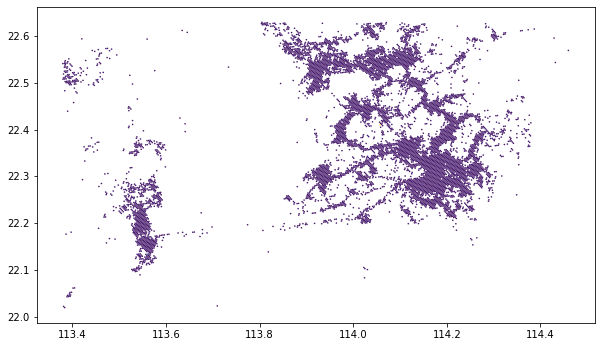

In [9]:
# Plot example
gdfchanges.plot('nonresidents_dif')
gdfchanges.crs

## 3. Spatial join with census tracks (typologies) data

This requires:

    An available function changes the geometry of the gdf to the centroids
    Load your typologies data to a geodataframe
    Spatial join

In [10]:
#1 Get centroids
gdfchanges_points = myh3.df_with_hexid_to_centroids_gdf(gdfchanges, hexcolname='_id')

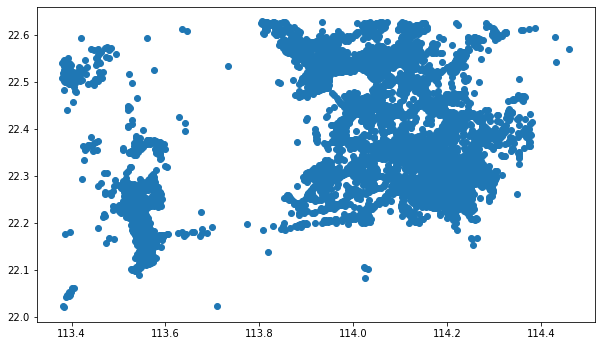

In [11]:
gdfchanges_points.plot()

In [12]:
# Load your typologies data as a geodataframe 
from pathlib import Path, PureWindowsPath
shp_path = Path("../../../../Box/Twitter data/Observation Shapefiles")

tracts = gpd.read_file(shp_path/"hk.geojson")
tracts = tracts.to_crs({'init': 'epsg:4326'})

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

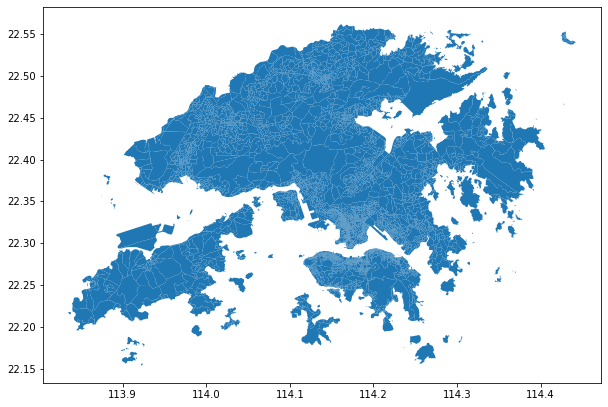

In [13]:
tracts.plot()
tracts.crs

In [14]:
# plot tweets with map as the base 

In [15]:
# # 3 Spatial Join between centroids and census track shapes
tweets_tracts=gpd.sjoin(gdfchanges_points, tracts, how="inner", op='intersects')

C:\Users\emman\AppData\Local\Continuum\anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [16]:
tweets_tracts.head()

,_id,nonresidents_dif,nonresidentsandnonneighbors_dif,residents_dif,totalcounts_dif,nonresidents_p0,nonresidentsandnonneighbors_p0,residents_p0,totalcounts_p0,nonresidents_ch,...,TPU,SB_VC,TYPE_Eng,TYPE_TC,TYPE_SC,Shape_Length,Shape_Area,category,label,standardized_types
7,8941034806fffff,-0.269841,-0.269841,NaN,-0.269841,0.555556,0.555556,NaN,0.555556,-0.485714,...,193,4,Street Blocks,街段統計區,街段统计区,2034.498942,126925.175917,6,No Category,Other
8,89410348203ffff,-0.486111,-0.486111,NaN,-2.041667,1.111111,1.111111,14.000000,2.666667,-0.437500,...,192,15,Street Blocks,街段統計區,街段统计区,6235.958952,785764.254109,1,Not Currently at Risk of Displacement,"Low Income, Stable"
10,8941034820bffff,195.111111,-6.333333,99.222222,224.111111,33.666667,10.444444,6.111111,39.777778,5.795380,...,192,15,Street Blocks,街段統計區,街段统计区,6235.958952,785764.254109,1,Not Currently at Risk of Displacement,"Low Income, Stable"
12,89410348217ffff,-9.222222,-9.222222,0.208333,-9.111111,17.111111,17.111111,0.666667,17.777778,-0.538961,...,192,15,Street Blocks,街段統計區,街段统计区,6235.958952,785764.254109,1,Not Currently at Risk of Displacement,"Low Income, Stable"
13,8941034821bffff,20.763889,-2.236111,NaN,20.763889,4.111111,4.111111,NaN,4.111111,5.050676,...,192,15,Street Blocks,街段統計區,街段统计区,6235.958952,785764.254109,1,Not Currently at Risk of Displacement,"Low Income, Stable"


In [17]:
typo_stats = tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem'])
#nonresidents_p0
typo_stats

nonresidents_dif                   \
                                          mean count        sem   
standardized_types                                                
Exclusive Static                    -18.648126   440   9.265573   
Low Income, At Risk of Change       -31.328005   398  10.424849   
Low Income, Stable                  -18.433719  1477   3.276807   
Low Income, Undergoing Change        -8.606660   216   6.923166   
Other                                22.069601  1242  39.771776   

                              nonresidents_ch                 nonresidents_p0  \
                                         mean count       sem            mean   
standardized_types                                                              
Exclusive Static                     1.309016   440  0.650421       47.248112   
Low Income, At Risk of Change        0.027170   398  0.089032       63.745020   
Low Income, Stable                   0.839111  1477  0.290494       47.607264   
Low Income, Undergoing Change        0.209410   216  0.108716       31.636558   
Other                                0.547251  1242  0.186007       48.585065   

                                                
                              count        sem  
standardized_types                              
Exclusive Static                442  14.666666  
Low Income, At Risk of Change   398  12.986840  
Low Income, Stable             1480   5.522441  
Low Income, Undergoing Change   216   8.045224  
Other                          1243   4.767627

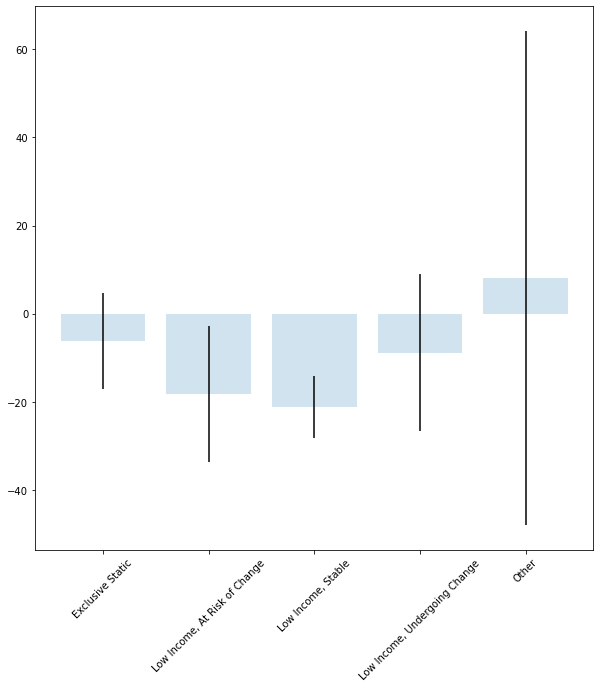

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.bar(typo_stats.index, typo_stats['nonresidents_dif','mean'], yerr=1.96*typo_stats['nonresidents_dif','sem'], alpha=0.2)
plt.xticks(rotation=45)
plt.show()

In [30]:
import matplotlib.pyplot as plt

def barchart(tweets_tracts, metric, title):
    
    #Windsorizing series to tream outliers 
    tweets_tracts['nonresidents_dif']=tweets_tracts['nonresidents_dif'].clip(lower= -60, upper=1000)
    tweets_tracts['nonresidents_ch']=tweets_tracts['nonresidents_ch'].clip(upper=6)
    
    #tweets_tracts['nonresidents_ch'].hist()
    typo_stats=tweets_tracts[['nonresidents_dif','nonresidents_ch', 'nonresidents_p0', 'standardized_types']].groupby('standardized_types').agg(['mean','count','sem','std'])
    
    typo_stats=typo_stats.reset_index()
    
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON_POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='NON POP']
    typo_stats=typo_stats.loc[typo_stats.standardized_types!='OTHER']
    
    
    #Sorting 
    typo_stats=typo_stats.sort_values(by=(metric,'mean'), ascending=False)
    
    fig, ax = plt.subplots()
    ax.bar(typo_stats['standardized_types'], typo_stats[metric,'mean'], yerr=1.96*typo_stats[metric,'sem'], alpha=0.2)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

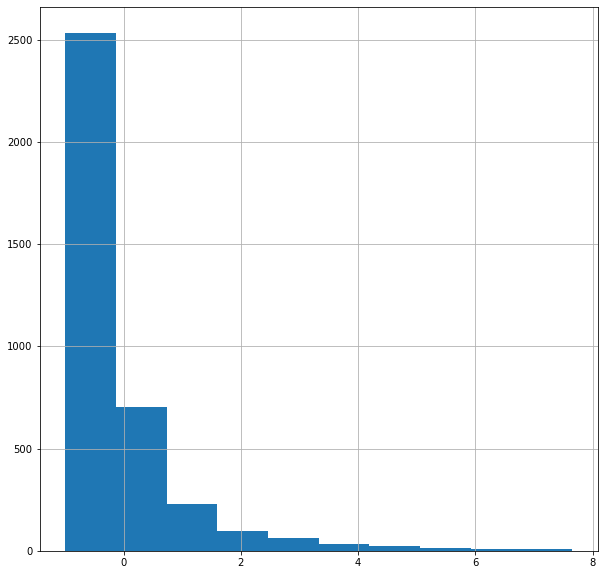

In [31]:
tweets_tracts.loc[tweets_tracts.nonresidents_ch<8].nonresidents_ch.hist()

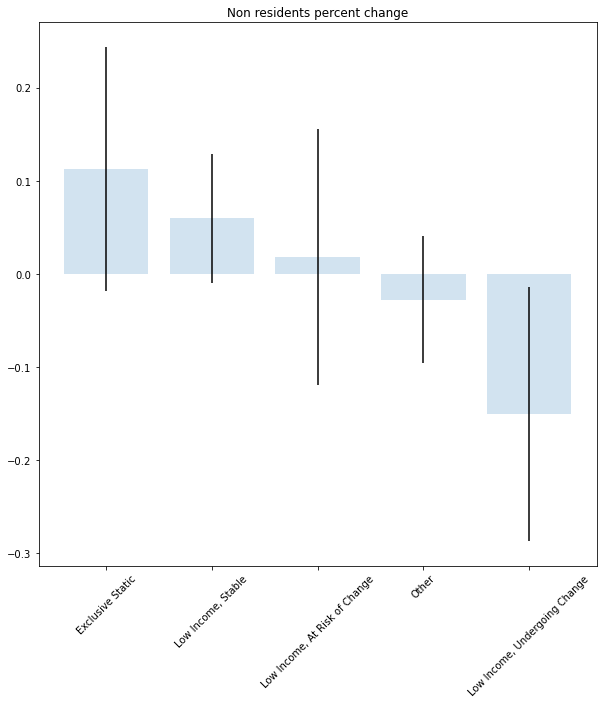

In [32]:
barchart(tweets_tracts, 'nonresidents_ch', title="Non residents percent change")

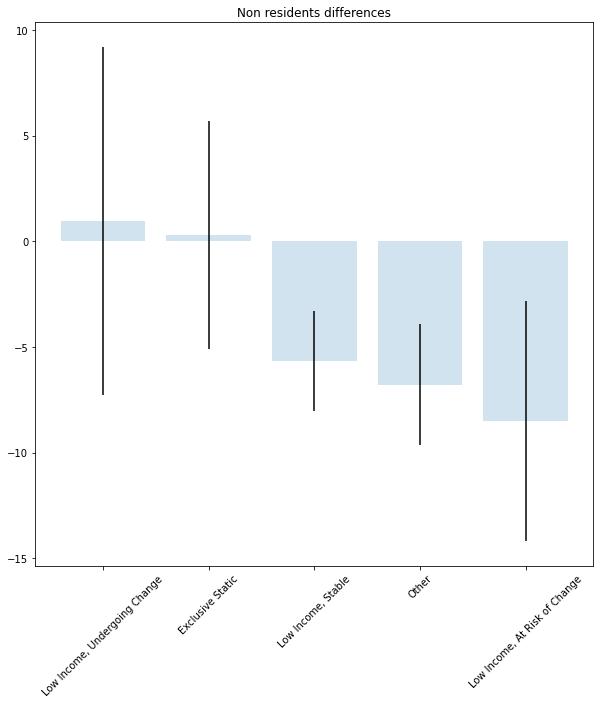

In [33]:
barchart(tweets_tracts, 'nonresidents_dif', title="Non residents differences")